## The code for figure 3 - studying peaks of dynamical correlation

In [1]:

import h5py
import mne
import numpy as np
import scipy.stats as stats
import scipy
import pandas as pd
from os.path import join as pjoin
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import matplotlib.cm as cm
import random
import os
import pickle
import warnings 
import matplotlib
from lempel_ziv_complexity import lempel_ziv_complexity
import seaborn as sns

import saving as sv
import mattepy as mp
import utils_avalanches as av
import Utils_FC as fc

warnings.simplefilter('ignore')

#path='/home/jeremy/anaconda3/matteo/'
path='C:/Users/matte/OneDrive/Documenti/matteo/'
#CREATING THE LIST OF SUBJECTS

In [2]:

sound_list=['rest','music','speech']
arr_mu = os.listdir(path +'seeg_fif_data/music')
arr_rest = os.listdir(path +'seeg_fif_data/speech')
arr_speech = os.listdir(path +'seeg_fif_data/rest')

subject_set_mu=set()
subject_set_speech=set()
subject_set_rest=set()

for st in arr_mu: 
    #print(st)
    subject_set_mu.add(st.partition('_')[0])
    #print(st.partition('_')[0])
    
for st in arr_speech:
    subject_set_speech.add(st.partition('_')[0])
    
for st in arr_rest:
    subject_set_rest.add(st.partition('_')[0])

subject_list=list(subject_set_mu.intersection(subject_set_speech,subject_set_rest))

#Here I create a set of the  all channels
total_channels_set=set()

for subject in subject_list:
    with h5py.File(pjoin(path +'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
        #print(f.keys())
        #print('chnames', f['chnames'].shape)
        
        chnames = f['chnames'][...].astype('U')
        total_channels_set.update(chnames)
        
#print(total_channels_set)


#Here I create a set of the H channels
ch_H=set()
for ch in total_channels_set:
    
    if "H" in ch:
        ch_H.add(ch)

#Here I create another set of channels        
ch_IM=set()
for ch in total_channels_set:
    
    if "IP" in ch:
        ch_IM.add(ch)
#print(ch_H)



In [3]:

channels={}
for isub,subject in enumerate(subject_list):   
    channels[subject]={}         

    with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
    #print(f.keys())
    #print('chnames', f['chnames'].shape)

        chnames = f['chnames'][...].astype('U')
        x=f['chlocs']
    if subject in ('sub-83ebd5328120', 'sub-aea837fa1826', 'sub-a4e7fc9daa96'):
        chnames = np.array([x.replace('Ip', "IP") for x in chnames])
        chnames = np.array([x.replace('p', "'") for x in chnames])
        chnames = np.array([x.replace('PIP', "PI'") for x in chnames])

    with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
    #print(f.keys())
    #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

        bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

    ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
    channels[subject]['clean']=ch_i
    chnames=chnames[ch_i]
    
    channels[subject]['H']=[]
    for i_c, ch in enumerate(chnames):
        
        if 'H' in ch:
            channels[subject]['H'].append(i_c)



    # collect coordinates for this specific orientation (only one patient)
    with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

        coordinates=f['mayavi'][orientation]['xy'][...]

    coordinates=coordinates[ch_i]

    # make sure you only select the left electrodes for the left orientation and
    # right electrodes for the right orientation


    if orientation in ('left', 'right'):

        _, _, left_i, right_i = mp.split_hemis(chnames)
        channels[subject]['left']=left_i
        channels[subject]['right']=right_i
        x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
    


                
                    

NameError: name 'orientation' is not defined

[87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

Computation subject list 

In [4]:
datatipe='hgenv_down100'
engagement={}
data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    engagement[subject]={}
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
    for sound in ['speech', 'music']:
        engagement[subject][sound]={}
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        aval=avalanches['Zbin'][index_all[sound],:]
        engag=np.sum(aval, axis=0)
        engagement[subject][sound]['p_value']=[]
        engagement[subject][sound]['std']=[]
        for i, engr in enumerate(engag):
            engagement[subject][sound]['p_value'].append(len(np.where(engagement_null[subject][sound][i,:]>engr)[0])/len(engagement_null[subject][sound][i,:]))
            engagement[subject][sound]['std'].append((engr-np.mean(engagement_null[subject][sound][i,:]))/np.std(engagement_null[subject][sound][i,:]))
            
        engagement[subject][sound]['p_value']=np.array(engagement[subject][sound]['p_value'])
        engagement[subject][sound]['std']=np.array(engagement[subject][sound]['std'])
        
"""        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
           
    
    engagement_null=np.array(engagement_null)
    plt.hist(engagement_null[0])
    plt.show()
    plt.close()
    engagement_null_mean['speech'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['speech'][subject]=np.std(engagement_null, axis=0)
    
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        
        indices=random.sample(range(len(avalanches['Zbin'])), mem['music'])
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['music'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['music'][subject]=np.std(engagement_null, axis=0)
    
sv.saving(engagement_null_mean, path+'engagement_null_mean_9495')
sv.saving(engagement_null_std, path+'engagement_null_std_9495')

    

    #speech null model
    avalanches=av.go_avalanches(zdata['speech'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['speech'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['speech'][subject]=np.std(engagement_null, axis=0)
    
    
    #music null model
    avalanches=av.go_avalanches(zdata['music'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['music'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['music'][subject]=np.std(engagement_null, axis=0)
    
""" 



2.734310175019014


NameError: name 'index_all' is not defined

In [ ]:
enga={}
for sound in ['speech','music']:
    enga[sound]={}
    eng_total=engagement[subject_list[0]][sound]['std']
    for subject in subject_list[1:]:
        np.concatenate((eng_total,engagement[subject][sound]['std']))
    
    #thres_std=np.percentile(eng_total, 99)
    for subject in subject_list:
        pvalue=0.05
        thres_std=max(np.percentile(engagement[subject][sound]['std'],98),5)
        enga[sound][subject]=np.where(engagement[subject][sound]['std']>thres_std,1,0)
        print(subject, len(np.where(engagement[subject][sound]['std']>thres_std)[0]))
        

sub-9d783b836f5e 3
sub-28e70e7c7fbb 2
sub-14c725b6b803 4
sub-c1b7ce54ce05 3
sub-ebf231d97f73 0
sub-83ebd5328120 2
sub-26176ef8a8d0 1
sub-e0bb6ccef2a5 1
sub-95a634be7e05 2
sub-fccb4adbfadc 2
sub-44375d501493 1
sub-a4e7fc9daa96 3
sub-aea837fa1826 4
sub-45a6830d263e 2
sub-c2a96116ddc4 3
sub-cacae171ee15 1
sub-3ef8645f99c5 1
sub-4247d6d6cdbf 1
sub-9d783b836f5e 3
sub-28e70e7c7fbb 0
sub-14c725b6b803 4
sub-c1b7ce54ce05 3
sub-ebf231d97f73 3
sub-83ebd5328120 0
sub-26176ef8a8d0 1
sub-e0bb6ccef2a5 3
sub-95a634be7e05 3
sub-fccb4adbfadc 3
sub-44375d501493 2
sub-a4e7fc9daa96 2
sub-aea837fa1826 2
sub-45a6830d263e 3
sub-c2a96116ddc4 3
sub-cacae171ee15 0
sub-3ef8645f99c5 2
sub-4247d6d6cdbf 3


In [ ]:
enga={}
for sound in ['speech','music']:
    enga[sound]={}
    eng_total=engagement[subject_list[0]][sound]['std']
    for subject in subject_list[1:]:
        np.concatenate((eng_total,engagement[subject][sound]['std']))
    
    #thres_std=np.percentile(eng_total, 99)
    for subject in subject_list:
        pvalue=0.05
        thres_std=max(np.percentile(engagement[subject][sound]['std'],98),5)
        enga[sound][subject]=np.where(engagement[subject][sound]['std']>thres_std,1,0)
        print(subject, len(np.where(engagement[subject][sound]['std']>thres_std)[0]))
        

sub-9d783b836f5e 3
sub-28e70e7c7fbb 2
sub-14c725b6b803 4
sub-c1b7ce54ce05 3
sub-ebf231d97f73 0
sub-83ebd5328120 2
sub-26176ef8a8d0 1
sub-e0bb6ccef2a5 1
sub-95a634be7e05 2
sub-fccb4adbfadc 2
sub-44375d501493 1
sub-a4e7fc9daa96 3
sub-aea837fa1826 4
sub-45a6830d263e 2
sub-c2a96116ddc4 3
sub-cacae171ee15 1
sub-3ef8645f99c5 1
sub-4247d6d6cdbf 1
sub-9d783b836f5e 3
sub-28e70e7c7fbb 0
sub-14c725b6b803 4
sub-c1b7ce54ce05 3
sub-ebf231d97f73 3
sub-83ebd5328120 0
sub-26176ef8a8d0 1
sub-e0bb6ccef2a5 3
sub-95a634be7e05 3
sub-fccb4adbfadc 3
sub-44375d501493 2
sub-a4e7fc9daa96 2
sub-aea837fa1826 2
sub-45a6830d263e 3
sub-c2a96116ddc4 3
sub-cacae171ee15 0
sub-3ef8645f99c5 2
sub-4247d6d6cdbf 3


NameError: name 'enga' is not defined

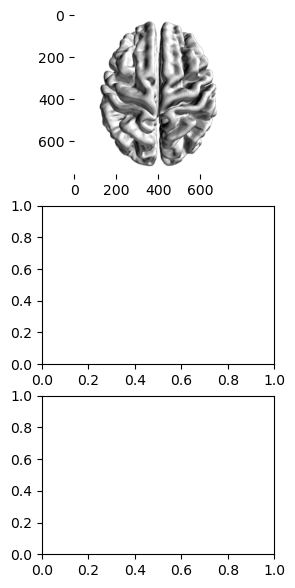

In [4]:
for o, sound in enumerate(['speech','music']):
    fig, ax= plt.subplots(3,1, figsize=(3,7))
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                """if orientation == 'left':
                    cmap=[]
                    for i in range(len(engagement[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(engagement[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject][right_i]))[i,:]))"""
                
                    
                    
            elif orientation == 'top':
                """cmap=[]
                for i in range(len(engagement[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject]))[i,:]))"""
                x_h = coordinates
                
                
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color='red', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject][left_i]))
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color='red', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject][right_i]))
                
            if orientation =='top':
                axes.scatter(*x_h.T, color='red', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject]))

                
            #axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])

    plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.savefig(path+'figure/brain_plots_all_channels_peaks_std_99_percentile_major5_'+sound+'.png', dpi=600)


In [5]:
window_length=50
time_interval=1

dcorr_all=sv.loading(path+'dcorr_all_'+str(window_length)+'_'+str(time_interval))


ind_all={}

for sound in sound_list:
    
    corr_thres_l=np.percentile(dcorr_all[sound], 99)
    #corr_thres_h=np.percentile(dcorr_all[sound], 71)
    print(corr_thres_l)
    aa=set(np.where(dcorr_all[sound]>corr_thres_l)[0])
    #bb=set(np.where(dcorr_all[sound]<corr_thres_h)[0])
    print(len(aa))
    ind_all[sound]=list(aa)
    print(len(aa))
    #In the following line a different methdod per subject was studied
    """for subject in subject_list:
    
        corr_thres=np.percentile(dcorr[sound][subject], 99)

        ind[sound][subject]=np.where(dcorr[sound][subject]>corr_thres)[0]"""


0.03505523940293846
283
283
0.07664808867366665
289
289
0.0577219974493764
287
287


In [6]:
index_all=dict()
for sound in sound_list:
    
    aall=set()
    for i in ind_all[sound]:
        aall.update(np.arange(i,i+window_length))
            
    index_all[sound]=list(aall)

mem={}
m=min(len(index_all['speech']), len(index_all['music']))
print(len(index_all['speech']), len(index_all['music']), len(index_all['rest']))
for sound in ['speech', 'music', 'rest']:
    #index_all[sound]=index_all[sound][:m]
    mem[sound]=len(index_all[sound])


1184 783 1847


In [46]:
datatipe='hgenv_down100'
eng_simple={}
eng_simple_all={}
#data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    eng_simple[subject]={}
    eng_simple_all[subject]={}
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
    for sound in sound_list:

        with h5py.File(pjoin(path+'seeg_data_hgenv_down100_h5py/', subject + '_down100_seeg_preproc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('music', f['music'].shape)

            #data_music[subject]=f['music'][...]
            data_raw=f[sound][...]
            
            #Here we delete the time point of the rest that correspond to the end and beginning of the three sessions
            if sound=='rest':
                index_del=np.concatenate((np.arange(int(len(data_raw[0,:])/3)-200,int(len(data_raw[0,:])/3)+200),np.arange(int(len(data_raw[0,:])*2/3)-200,int(len(data_raw[0,:])*2/3)+200)))   
                data_raw=np.delete(data_raw, index_del, axis=1)

            data_raw=data_raw[:,100:-100]

        #Here we load the channels names
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
            print(f.keys())
            print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            print(f.keys())
            print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]

        clean= np.delete(data_raw, ch_i, axis=0)

        #List of indices of H channels, list of indices of not H channels
        channels[subject]['H']= [i for i, ch in enumerate(clean_chnames) if ch in ch_H]
        ch_H_w_i= [i for i, ch in enumerate(clean_chnames) if ch not in ch_H]

        #dictionaries with subjects ad keys and channels names
        


        #HERE WE CREATE THE DATA SET, THAT WE USE
        #only the channels in Helsch gyrus
        clean_H = np.delete(clean, channels[subject]['H'], axis=0)

        #only the channels not in the helsch gyrus
        clean_without_H = np.delete(clean, ch_H_w_i, axis=0)

        #clean_mu=clean2(clean_music_H, N=3)
        #clean_sp=clean2(clean_speech_H, N=3)
        #clean_re=clean2(clean_rest_H, N=3)

        #zscore of the data
        zdata_art=stats.zscore(clean, axis=1)

        #the artifacts are substituted by 0
        zdata_=np.where(np.abs(zdata_art)>5, 0, zdata_art)

        #zscored computed again
        zdata=stats.zscore(zdata_, axis=1)
        avalanches=av.go_avalanches(zdata.T, thre=thres, direc=0, binsize=2)
        aval=avalanches['Zbin'][index_all[sound],:]
        eng_simple[subject][sound]=scipy.stats.zscore(np.sum(aval, axis=0))
        eng_simple_all[subject][sound]=scipy.stats.zscore(np.sum(avalanches['Zbin'], axis=0))
        if max(channels[subject]['H'])>len(eng_simple[subject][sound]):
            print(len(eng_simple[subject][sound]), channels[subject]['H'])





    

    

2.7985919037396925
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (154,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'other', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (16,), type "|S11">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (154,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'other', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (16,), type "|S11">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (154,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'other', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (16,), type "|S11">
2.78534246404477
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi

In [42]:
eng_simple[subject][sound]

array([-0.5537496 , -0.42704419, -0.30033877, -0.5537496 , -0.5537496 ,
       -0.93386586, -0.93386586,  0.33318832,  0.2064829 , -0.93386586,
        0.07977749, -0.5537496 , -0.42704419, -0.5537496 , -0.42704419,
        1.72694792,  1.72694792,  0.58659916, -0.17363335,  1.09342083,
       -0.5537496 , -1.1872767 , -1.69409837, -0.93386586, -0.93386586,
       -0.04692793, -1.1872767 , -0.5537496 , -0.30033877, -1.56739295,
        1.6002425 ,  0.07977749, -0.42704419, -1.06057128, -0.42704419,
       -0.30033877, -0.17363335,  0.07977749,  0.84000999, -0.42704419,
        0.58659916, -0.42704419,  0.58659916, -0.80716044, -0.42704419,
       -0.04692793,  0.71330458,  0.71330458, -0.17363335, -0.42704419,
       -0.17363335,  0.58659916,  1.6002425 ,  0.58659916, -0.80716044,
       -0.68045502, -0.04692793,  2.23376959,  0.84000999, -0.80716044,
        0.33318832, -0.30033877,  0.07977749,  0.33318832,  1.09342083,
       -0.5537496 , -0.04692793, -0.80716044,  0.58659916,  1.22

In [37]:
channels[subject]['H']

[27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122]

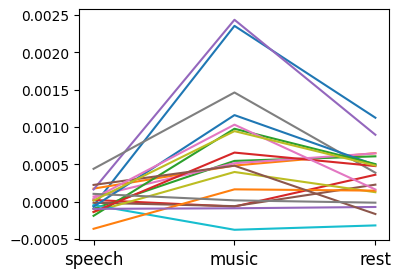

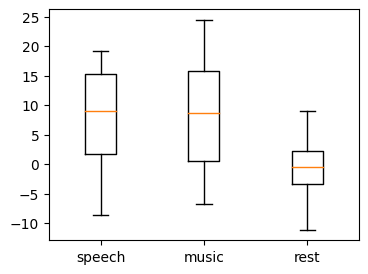

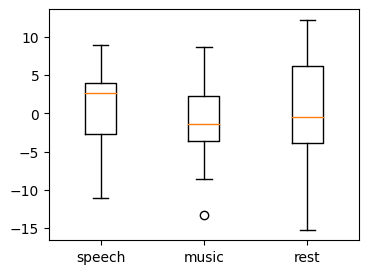

In [55]:
sound_list=['speech', 'music', 'rest']

fs=12
engag={}        
engag_all={}        
for subject in subject_list:
    engag[subject]=[]
    for sound in sound_list:
        engag[subject].append(np.sum(eng_simple[subject][sound][channels[subject]['H']]))
             
for subject in subject_list:
    engag_all[subject]=[]
    for sound in sound_list:
        engag_all[subject].append(np.sum(eng_simple_all[subject][sound][channels[subject]['H']]))
        

plt.figure(figsize=(4,3))
for subject in subject_list:
    plt.plot([np.mean(eng_simple[subject]['rest'][channels[subject]['H']])/mem['rest'],np.mean(eng_simple[subject]['music'][channels[subject]['H']])/mem['music'],np.mean(eng_simple[subject]['speech'][channels[subject]['H']])/mem['speech']])
plt.xticks([0,1,2], sound_list, fontsize=fs)
#plt.ylabel('H norm AE', fontsize=fs)
#plt.tight_layout()
plt.savefig(path+'figure/h_engagement_subjects_lines.png', dpi=600)
plt.show()
plt.close()

engag_boxplot=np.zeros((3,19))
engag_boxplot_all=np.zeros((3,19))

for i, sound in enumerate(sound_list):
    for j, subject in enumerate(subject_list):
        engag_boxplot_all[i,j]=engag_all[subject][i]

for i, sound in enumerate(sound_list):
    for j, subject in enumerate(subject_list):
        engag_boxplot[i,j]=engag[subject][i]

plt.figure(figsize=(4,3))
plt.boxplot(list(engag_boxplot), labels=sound_list)
#plt.legend(fontsize=fs)
#plt.ylabel('H norm AE', fontsize=fs)
#plt.tight_layout()
plt.savefig(path+'figure/h_engagement_boxplot.png', dpi=600)
plt.show()
plt.close() 

plt.figure(figsize=(4,3))
plt.boxplot(list(engag_boxplot_all), labels=sound_list)
#plt.legend(fontsize=fs)
#plt.ylabel('H norm AE', fontsize=fs)
#plt.tight_layout()
plt.savefig(path+'figure/h_engagement_boxplot.png', dpi=600)
plt.show()
plt.close()  

scipy.stats.wilcoxon(engag_boxplot[0,:],engag_boxplot[1,:])

import seaborn as sns 
import pandas as pd

#df = pd.DataFrame(engag_boxplot, columns=['normalized_engagement']*19, index=sound_list)
#sns.kdeplot(data=df, y='normalized_engagement', fill=True,  alpha=.5, linewidth=0)
#from statsmodels.graphics.boxplots import violinplot

#fig, ax = plt.subplots()
#violinplot(data=df.values, ax=ax, labels=sound_list, side='right', show_boxplot=False)
#fig.autofmt_xdate()



In [52]:
scipy.stats.wilcoxon(engag_boxplot[0,:],engag_boxplot[2,:])


WilcoxonResult(statistic=21.0, pvalue=0.0016937255859375)

In the following part I performed a statistical test to confirm the fact that during speech and music listening the study of the engagement of H allows to perfectly distinguish between different conditions

In [12]:
#between speech and rest

real_diff=np.mean(engag_boxplot[2])-np.mean(engag_boxplot[0])
count=0
test_boxplot=np.concatenate((engag_boxplot[0], engag_boxplot[2]))

for i in range(100000):
    aa=np.array(random.sample(list(test_boxplot),19))
    bb=np.array([i for i in test_boxplot if i not in aa])
    diff=np.mean(aa)-np.mean(bb)
    if diff>real_diff:
        count +=1

    

In [13]:
count/100000

0.00094

## trough studies, not correlated instant of time 

Here we study those moment when correlation is not highe 

In [241]:

datatipe='hgenv_down100'
engagement={}
enga_null={}

data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)

    engagement_nu=[]
    
    for i in np.arange(0, len(avalanches['Zbin'])-50,1):
        aval=avalanches['Zbin'][i:i+50, :]
        engagement_nu.append(np.sum(aval, axis=0)/50)
        
    enga_null[subject]=np.array(engagement_nu)



2.818625307029934
2.7331326834817284
2.7507264122036497
2.9744978125454247
2.750861898649132
2.803148765547773
2.734310175019014
2.897258743666651
2.78534246404477
3.334984151824247
2.8089245753814596
2.7761437719778965
2.8552720483703933
2.7654285000333187
2.79738475441734
2.774284818922206
2.7742837529435107
2.8138171563785437
2.7985919037396925


In [140]:

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)
    
    
    #speech null model
    avalanches=av.go_avalanches(zdata['speech'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['speech'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['speech'][subject]=np.std(engagement_null, axis=0)
    
    
    #music null model
    avalanches=av.go_avalanches(zdata['music'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['music'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['music'][subject]=np.std(engagement_null, axis=0)
    
    
for sound in ['music', 'speech']:
    
    engagement[sound]={}    
    engagementr[sound]={}
    meta_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index_all[sound],:]
        print(min(np.sum(aval, axis=1)))
                                                           
        engagementt=np.sum(aval, axis=0)

        engagement[sound][subject]=(engagementt-engagement_null_mean[subject])/engagement_null_std[subject]
        
        meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
           
        engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        print(engagement[sound][subject])
        
sv.saving(engagement, path+'engagement_troughs')
sv.saving(meta_engagement, path+'meta_engagement_troughs' )


2.7761437719778965
2.9744978125454247


KeyboardInterrupt: 

In [242]:
enga_null[subject_list[0]].shape



(566, 150)

In [243]:

engagement={}

for sound in ['music', 'speech']:
    
    engagement[sound]={}    
    
    for subject in subject_list:
        print(subject)
        zdata=data[subject]  #loading the data of the three conditions that we saved before 
        
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
            #print(f.keys())
            #print('chnames', f['chnames'].shape)
            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
            #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)     
        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index_all[sound],:]
                                                               
        engagementt=np.sum(aval, axis=0)/mem[sound]
        
        sum_enga_null=np.sum(enga_null[subject], axis=1)
        
        print(np.sum(engagementt))
        
        aa=set(np.where(sum_enga_null>np.sum(engagementt)-0.1)[0])

        bb=set(np.where(sum_enga_null<np.sum(engagementt)+0.2)[0])
        
        print(len(aa.intersection(bb)))
        
        mean_null=np.mean(enga_null[subject][list(aa.intersection(bb)),:], axis=0)
        
        enn=[]
        for i in range(len(engagementt)):
            aaa=len(np.where(enga_null[subject][list(aa.intersection(bb)),i]>engagementt[i])[0])
            bbb=len(np.where(enga_null[subject][list(aa.intersection(bb)),i]<engagementt[i])[0])
            enn.append(aaa/(bbb+1))
            #plt.title(clean_chnames[i])
            #plt.hist(enga_null[subject][list(aa.intersection(bb)),:][i])
            #plt.axvline(engagementt[i])
            #plt.show()
            #plt.close()
            
        engagement[sound][subject]=np.array(enn)
        
        #std_null=np.std(enga_null[subject][list(aa.intersection(bb)), :], axis=0)
        
        #engagement[sound][subject]=(engagementt-mean_null)/std_null
        
        #meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
           
        #engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        #print(engagement[sound][subject])
        
sv.saving(engagement, path+'engagement_peaks_same_sum')
#sv.saving(meta_engagement, path+'meta_engagement_peaks' )

sub-3ef8645f99c5
2.818625307029934
(28918, 150)
2.3228066146072575
66
sub-95a634be7e05
2.7331326834817284
(28918, 151)
2.392397795130914
109
sub-14c725b6b803
2.7507264122036497
(28918, 168)
2.638033991731741
115
sub-aea837fa1826
2.9744978125454247
(28918, 167)
2.5312356453835556
61
sub-ebf231d97f73
2.750861898649132
(28918, 146)
2.303858520900322
101
sub-28e70e7c7fbb
2.803148765547773
(28918, 117)
1.8155718879191547
121
sub-cacae171ee15
2.734310175019014
(28918, 116)
1.7624023886081766
131
sub-44375d501493
2.897258743666651
(28918, 157)
2.451998162609095
114
sub-e0bb6ccef2a5
2.78534246404477
(28918, 110)
1.6995865870463942
157
sub-82e330f8aadd
3.334984151824247
(28918, 147)
2.3720716582452916
6
sub-83ebd5328120
2.8089245753814596
(28918, 121)
1.8870004593477263
105
sub-4247d6d6cdbf
2.7761437719778965
(28918, 108)
1.726228755167662
109
sub-fccb4adbfadc
2.8552720483703933
(28918, 109)
1.698897565457051
111
sub-9d783b836f5e
2.7654285000333187
(28918, 123)
2.0527101515847495
93
sub-26176ef

In [2]:
abb=[]
app=[]

for k in [0.1]:
    count2=0
    count=0

    for i in range(18):
        print(len(np.where(np.array(engagement['speech'][subject_list[i]])<k)[0]))
        count+=len(np.where(np.array(engagement['speech'][subject_list[i]])<k)[0])
        count2+=len(np.where(np.array(engagement['speech'][subject_list[i]])<k)[0])
    abb.append(count)
    app.append(count2)

print(count)
plt.plot(abb)
plt.plot(app)

NameError: name 'np' is not defined

Analisi, facciamo variare le soglie di correlazione massima e minima e vediamo che succede alle regioni significative. Vogliamo far vedere che nei momenti in cui i soggetti sono molto correlati ci sono cose in h e regioni di interesse

In [50]:
datatipe='hgenv_down100'
engagement={}
enga_null={}

data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)

    engagement_nu=[]
    
    for i in np.arange(0, len(avalanches['Zbin'])-50,1):
        aval=avalanches['Zbin'][i:i+50, :]
        engagement_nu.append(np.sum(aval, axis=0)/50)
        
    enga_null[subject]=np.array(engagement_nu)


engagement={}

window_length=50
time_interval=1

dcorr_all=sv.loading(path+'dcorr_all_'+str(window_length)+'_'+str(time_interval))

for per in np.arange(0,100, 9)[1:]:

    ind_all={}
    engagement[per]={}
    
    for sound in sound_list:
    
        corr_thres_l=np.percentile(dcorr_all[sound], per)
        corr_thres_h=np.percentile(dcorr_all[sound], per+1)
        print(corr_thres_l, corr_thres_h)
        aa=set(np.where(dcorr_all[sound]>corr_thres_l)[0])
        bb=set(np.where(dcorr_all[sound]<=corr_thres_h)[0])
        print(len(aa), len(bb))
        ind_all[sound]=list(aa)
        print(len(aa.intersection(bb)))
    
    index_all=dict()
    for sound in sound_list:
    
        aall=set()
        for i in ind_all[sound]:
            aall.update(np.arange(i,i+window_length))
            
        index_all[sound]=list(aall)

    mem={}
    m=min(len(index_all['speech']), len(index_all['music']))
    print(len(index_all['speech']), len(index_all['music']), len(index_all['rest']))
    for sound in ['speech', 'music', 'rest']:
        #index_all[sound]=index_all[sound][:m]
        mem[sound]=len(index_all[sound])
    
    for sound in ['music', 'speech']:
    
        engagement[per][sound]={}    

        for subject in subject_list:
            print(subject)
            zdata=data[subject]  #loading the data of the three conditions that we saved before 

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

                #print(f.keys())
                #print('chnames', f['chnames'].shape)
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']

            #Here we load the list of bad channels
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
                #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
                #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

            ## Cleaning from artifacts
            #List of bad channels indices
            ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

            clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
                #the threshold is derived as the 99th percentile of the data
            thres=np.percentile(zdata['rest'], 99)
            print(thres)     

            #avalanches dictionaries are computed using the functions of Utils_avalanches.py
            avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)

            print(avalanches['Zbin'].shape)
            aval=avalanches['Zbin'][index_all[sound],:]

            engagementt=np.sum(aval, axis=0)/mem[sound]

            sum_enga_null=np.sum(enga_null[subject], axis=1)

            print(np.sum(engagementt))

            aa=set(np.where(sum_enga_null>np.sum(engagementt)-0.1)[0])

            bb=set(np.where(sum_enga_null<np.sum(engagementt)+0.1)[0])

            print(len(aa.intersection(bb)))

            mean_null=np.mean(enga_null[subject], axis=0)

            enn=[]
            for i in range(len(engagementt)):
                aaa=len(np.where(enga_null[subject][:,i]>engagementt[i])[0])
                bbb=len(np.where(enga_null[subject][:,i]<engagementt[i])[0])
                enn.append(aaa/(bbb+1))
                #plt.title(clean_chnames[i])
                #plt.hist(enga_null[subject][list(aa.intersection(bb)),:][i])
                #plt.axvline(engagementt[i])
                #plt.show()
                #plt.close()

            engagement[per][sound][subject]=np.array(enn)

            #std_null=np.std(enga_null[subject][list(aa.intersection(bb)), :], axis=0)

            #engagement[sound][subject]=(engagementt-mean_null)/std_null

            #meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]

            #engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))

            #print(engagement[sound][subject])

sv.saving(engagement, path+'engagement_percentile1__99_asound_asubject')

2.7507264122036497
2.7742837529435107
2.734310175019014
2.818625307029934
2.8089245753814596
2.7761437719778965
2.803148765547773
2.774284818922206
2.7654285000333187
2.79738475441734
2.9744978125454247
2.8138171563785437
2.78534246404477
2.7985919037396925
3.334984151824247
2.897258743666651
2.750861898649132
2.8552720483703933
2.7331326834817284
-0.016053813196017917 -0.015461240314665111
25739 2829
283
-0.013092963009911024 -0.012525597649224382
26269 2887
288
-0.01323864600553319 -0.012521295700879398
26103 2869
287
28685 28874 28294
sub-14c725b6b803
2.7507264122036497
(28918, 168)
2.6320911546720236
3684
sub-a4e7fc9daa96
2.7742837529435107
(28918, 115)
1.801863267991965
2437
sub-cacae171ee15
2.734310175019014
(28918, 116)
1.7712821223245825
4946
sub-3ef8645f99c5
2.818625307029934
(28918, 150)
2.2236267922698616
2270
sub-83ebd5328120
2.8089245753814596
(28918, 121)
1.886922490822193
3718
sub-4247d6d6cdbf
2.7761437719778965
(28918, 108)
1.6951582738796147
4524
sub-28e70e7c7fbb
2.803

(28735, 117)
1.769454623841345
4771
sub-c1b7ce54ce05
2.774284818922206
(28735, 135)
2.0253287346410866
2744
sub-9d783b836f5e
2.7654285000333187
(28735, 123)
1.9753179564561327
3688
sub-26176ef8a8d0
2.79738475441734
(28735, 86)
1.340482862685924
4057
sub-aea837fa1826
2.9744978125454247
(28735, 167)
2.3585542861248827
2132
sub-45a6830d263e
2.8138171563785437
(28735, 107)
1.5666091830135802
3670
sub-e0bb6ccef2a5
2.78534246404477
(28735, 110)
1.706258532729755
5371
sub-c2a96116ddc4
2.7985919037396925
(28735, 139)
2.1875763454767547
3517
sub-82e330f8aadd
3.334984151824247
(28735, 147)
2.3454049004814257
366
sub-44375d501493
2.897258743666651
(28735, 157)
2.4431630380110656
4100
sub-ebf231d97f73
2.750861898649132
(28735, 146)
2.1768700150894587
3733
sub-fccb4adbfadc
2.8552720483703933
(28735, 109)
1.671768340878063
3795
sub-95a634be7e05
2.7331326834817284
(28735, 151)
2.417403175971833
3457
-0.0055726531611229885 -0.005266205737888638
18102 10466
283
-0.00166818508949638 -0.00132483840183299

KeyboardInterrupt: 

preplotting 

In [49]:
engagement[99]['music']

{'sub-14c725b6b803': array([0.68149646, 0.30023456, 0.73953975, 0.81947484, 0.82146769,
        0.31670625, 0.60366442, 0.61770428, 0.95877503, 1.1824147 ,
        0.96572104, 0.68149646, 0.29315708, 0.86853933, 0.76165254,
        1.06840796, 0.42015371, 0.53413284, 0.76914894, 0.80173348,
        0.74684874, 0.60521236, 0.77481323, 0.32721468, 0.77481323,
        0.59596929, 0.55565949, 0.24104478, 0.6208577 , 0.43362069,
        0.87485908, 0.89840183, 0.33574297, 1.17670157, 0.82346491,
        0.77481323, 0.54553903, 0.77292111, 0.72510373, 0.73048907,
        0.76165254, 0.76914894, 0.27043545, 0.24943651, 0.96804734,
        1.22326203, 0.84777778, 0.69693878, 0.87274775, 0.69175992,
        0.8664422 , 0.28615623, 0.82948295, 1.08135169, 0.35644372,
        0.91810842, 0.67472306, 0.63520157, 0.44232437, 0.91810842,
        0.45749343, 0.43115318, 0.31462451, 0.62561095, 0.34221146,
        0.3509342 , 0.30944882, 0.78817204, 1.02311436, 0.82346491,
        1.09974747, 0.353132

In [43]:
enga={}
for per in np.arange(0,100,9)[1:]:
    print(per)
    enga[per]={}
    for sound in ['speech','music']:
        enga[per][sound]={}
        for subject in subject_list:
            pvalue=0.05
            if pvalue > min(engagement[per][sound][subject]):
                print('')
                print('yes')
            enga[per][sound][subject]=np.where(engagement[per][sound][subject]<pvalue,1,0)


9

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
18

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
27

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
36

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
45

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
54

yes

yes

yes

yes

yes

yes

yes

yes

yes
63

yes

yes

yes

yes

yes

yes

yes

yes
72

yes

yes

yes

yes

yes

yes

yes

yes
81

yes

yes

yes

yes

yes

yes

yes

yes
90

yes

yes

yes

yes

yes

yes

yes

yes

yes
99

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes


plotting

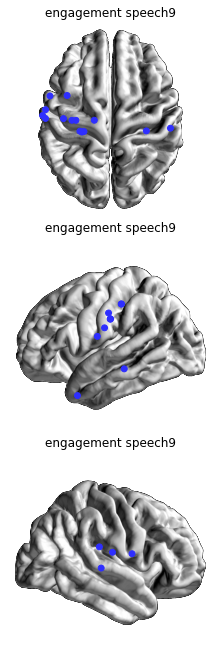

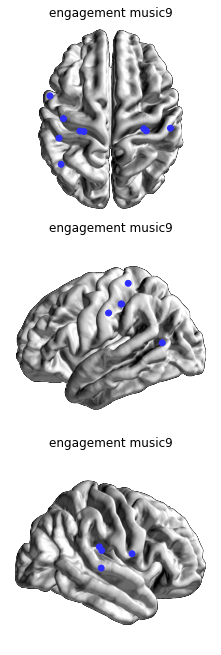

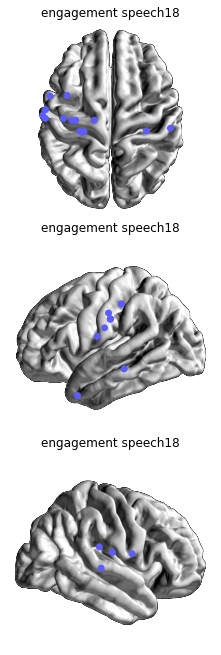

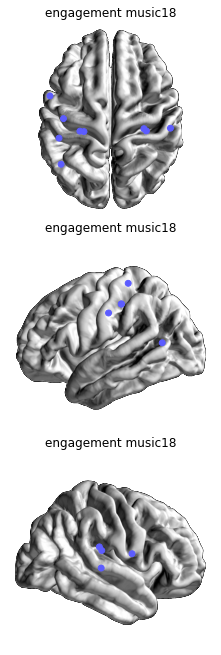

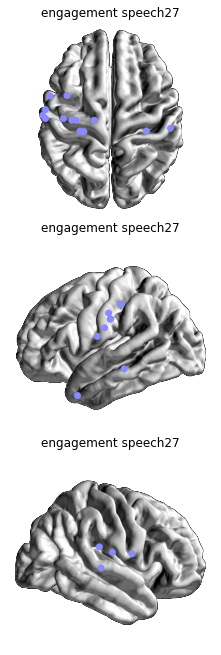

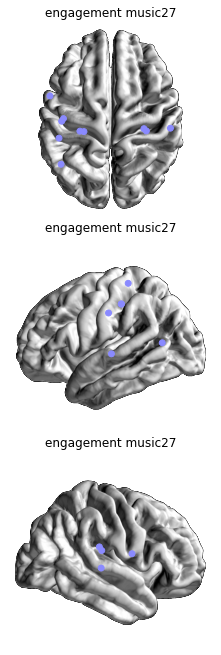

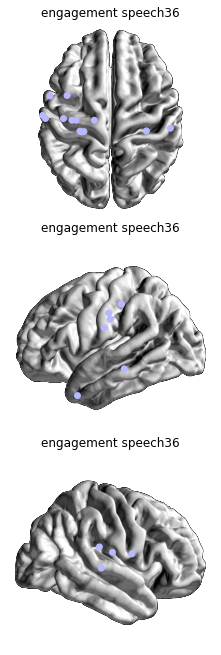

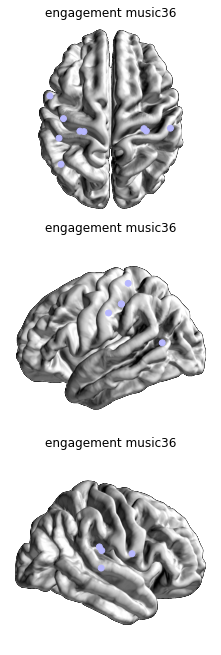

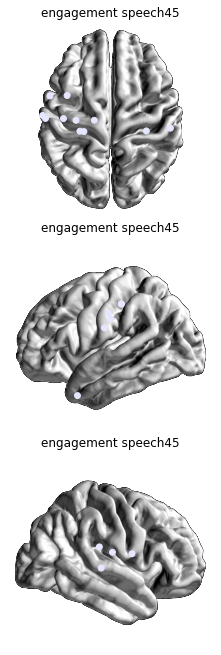

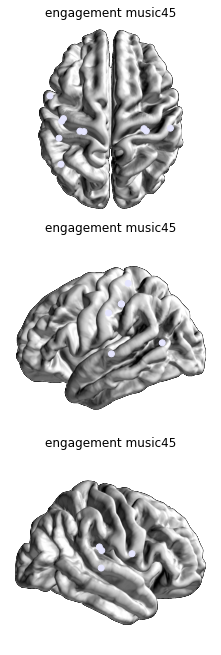

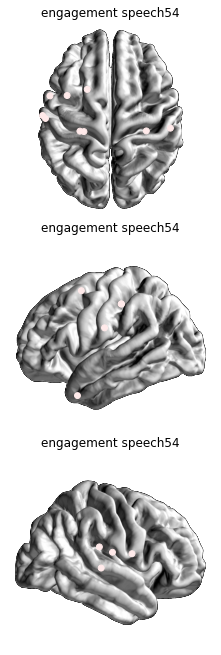

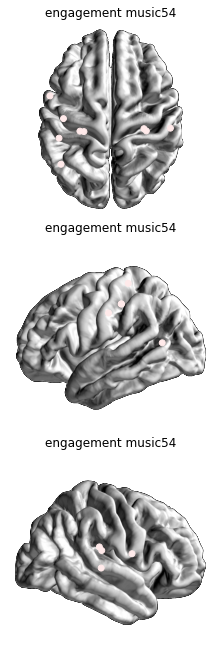

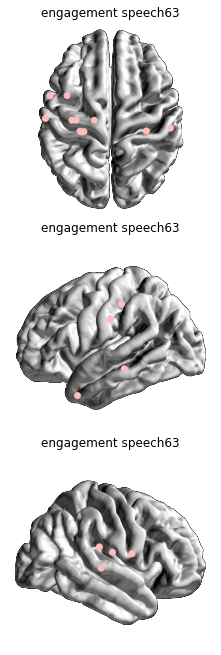

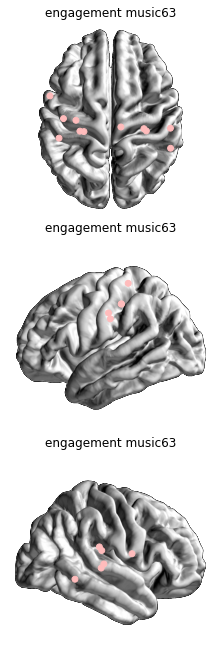

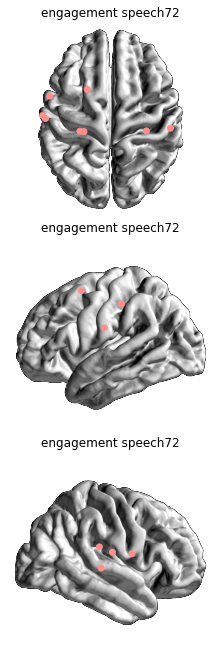

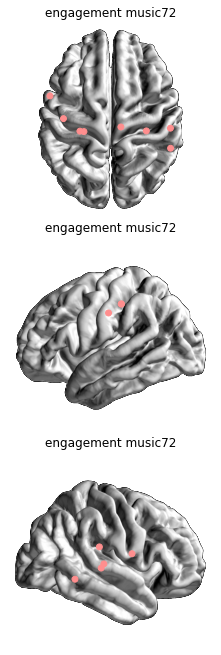

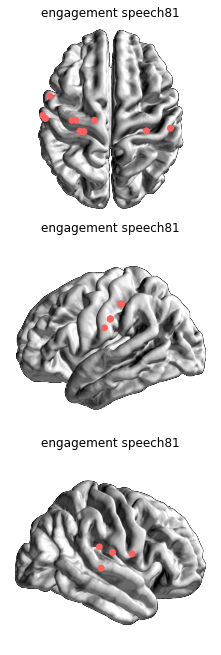

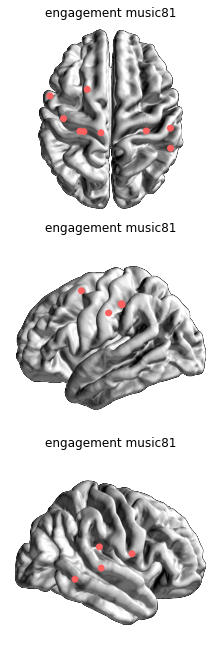

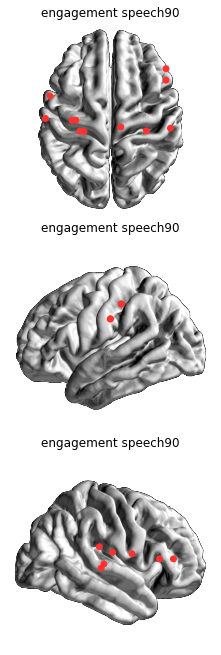

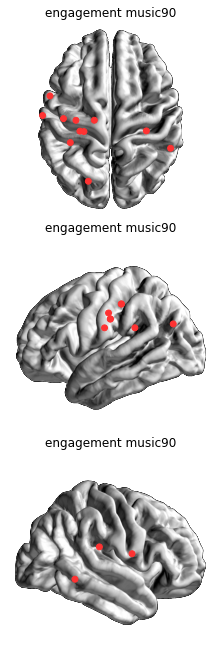

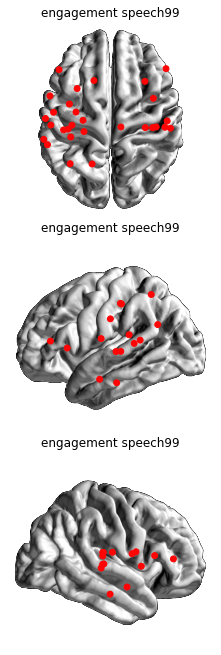

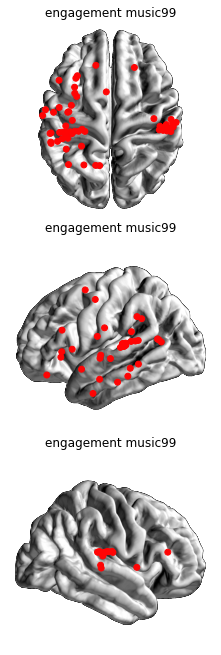

In [44]:

'''
#plotting
plt.figure(figsize=(3,1.7))
for subject in subject_list:
    plt.plot(mean_eng[subject])
plt.title('eng H - all subjects')
plt.xticks([0,1,2], ['speech','music','rest'], fontsize=10)
plt.ylabel('mean eng', fontsize=10)
plt.tight_layout()
plt.savefig(path+'figure/'+ 'engament of H - across conditions - all subjects', dpi=600)
plt.show()
plt.close()'''

for per in np.arange(0,100,9)[1:]:
    
    for o, sound in enumerate(['speech','music']):
        
        fig, ax= plt.subplots(3,1, figsize=(3,9))
        
        for j, orientation in enumerate(['top','left','right']):


            axes=ax[j]
            axes.spines['top'].set_visible(False)
            axes.spines['right'].set_visible(False)
            axes.spines['bottom'].set_visible(False)
            axes.spines['left'].set_visible(False)

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:

                im = f[orientation]['imp'][...]

            for isub,subject in enumerate(subject_list[:-1]):            

                with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                    #print(f.keys())
                    #print('chnames', f['chnames'].shape)

                    chnames = f['chnames'][...].astype('U')
                    x=f['chlocs']


                with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                    #print(f.keys())
                    #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

                    bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

                ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

                chnames=chnames[ch_i]

                # collect coordinates for this specific orientation (only one patient)
                with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

                    coordinates=f['mayavi'][orientation]['xy'][...]

                coordinates=coordinates[ch_i]

                # make sure you only select the left electrodes for the left orientation and
                # right electrodes for the right orientation


                if orientation in ('left', 'right'):

                    _, _, left_i, right_i = mp.split_hemis(chnames)
                    x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]

                    if orientation == 'left':
                        cmap=[]
                        for i in range(len(engagement[per][sound][subject][left_i])):
                            cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[per][sound][subject][left_i]))[i,:]))

                    if orientation == 'right':
                        cmap=[]
                        for i in range(len(engagement[per][sound][subject][right_i])):
                            cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[per][sound][subject][right_i]))[i,:]))



                elif orientation == 'top':
                    cmap=[]
                    for i in range(len(engagement[per][sound][subject])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[per][sound][subject]))[i,:]))
                    x_h = coordinates


                axes.imshow(im)
                if orientation =='left':
                    if left_i != []:
                        axes.scatter(*x_h.T, color=cm.bwr(per/100), s=35*np.ones(len(x_h)), marker='o', alpha=(enga[per][sound][subject][left_i]))

                if orientation =='right':

                    if right_i != []:
                        axes.scatter(*x_h.T, color=cm.bwr(per/100), s=35*np.ones(len(x_h)), marker='o', alpha=(enga[per][sound][subject][right_i]))

                if orientation =='top':
                    axes.scatter(*x_h.T, color=cm.bwr(per/100), s=35*np.ones(len(x_h)), marker='o', alpha=(enga[per][sound][subject]))


                axes.title.set_text('engagement '+sound+str(per))
                axes.set_xticks([])
                axes.set_yticks([])

        plt.tight_layout(pad=0.35)
        plt.savefig(path+'figure/brain_plots_all_channels_thres6std_9495'+sound+str(per)+'.png', dpi=600)


Analisi proposta da Fufo, contare quante volte durante tutto il tempo le mie regioni si allontanano da quello che spiegherebbe il rest. Io qua lo faccio comparando finestre di taglia simile.

In [46]:
datatipe='hgenv_down100'

enga_null={}

data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)

    engagement_nu=[]
    
    for i in np.arange(0, len(avalanches['Zbin'])-50,1):
        aval=avalanches['Zbin'][i:i+50, :]
        engagement_nu.append(np.sum(aval, axis=0)/50)
        
    enga_null[subject]=np.array(engagement_nu)


temporal_engagement={}

for sound in ['music', 'speech']:
    
    temporal_engagement[sound]={}    

    for subject in subject_list:
        print(subject)
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

            #print(f.keys())               #print('chnames', f['chnames'].shape)
            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)     

        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)

        print(avalanches['Zbin'].shape)
        
        enga_list=[]
        for winb in range(len(avalanches['Zbin'])-50):
            
            aval=avalanches['Zbin'][winb:winb+50,:]

            engagementt=np.sum(aval, axis=0)/50

            sum_enga_null=np.sum(enga_null[subject], axis=1)

            #print(np.sum(engagementt))

            aa=set(np.where(sum_enga_null>np.sum(engagementt)-0.1)[0])

            bb=set(np.where(sum_enga_null<np.sum(engagementt)+0.15)[0])

            #print(len(aa.intersection(bb)))

            mean_null=np.mean(enga_null[subject][list(aa.intersection(bb)),:], axis=0)

            enn=[]
            for i in range(len(engagementt)):
                aaa=len(np.where(enga_null[subject][list(aa.intersection(bb)),i]>engagementt[i])[0])
                bbb=len(np.where(enga_null[subject][list(aa.intersection(bb)),i]<engagementt[i])[0])
                enn.append(aaa/(bbb+1))
                
            enga_list.append(enn)
            
        temporal_engagement[sound][subject]=np.array(enga_list)

            #std_null=np.std(enga_null[subject][list(aa.intersection(bb)), :], axis=0)

            #engagement[sound][subject]=(engagementt-mean_null)/std_null

            #meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]

            #engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))

            #print(engagement[sound][subject])

#sv.saving(engagement, path+'engagement_percentile1__99_asound_asubject')

2.7507264122036497
2.7742837529435107
2.734310175019014
2.818625307029934
2.8089245753814596
2.7761437719778965
2.803148765547773
2.774284818922206
2.7654285000333187
2.79738475441734
2.9744978125454247
2.8138171563785437
2.78534246404477
2.7985919037396925
3.334984151824247
2.897258743666651
2.750861898649132
2.8552720483703933
2.7331326834817284
sub-14c725b6b803
2.7507264122036497
(28918, 168)


KeyboardInterrupt: 

In [33]:
engagement[9]['speech']

{'sub-14c725b6b803': array([0.75996016, 0.80122324, 0.81977343, 0.88983957, 0.91960891,
        0.64678472, 1.07151231, 0.68929254, 0.81603289, 0.74691053,
        0.70313253, 0.67092199, 0.79847328, 0.88178914, 0.76965448,
        0.82919255, 0.67092199, 0.57697456, 0.79390863, 0.80122324,
        0.78214826, 0.63990719, 1.00681431, 0.9248366 , 0.77320622,
        0.69903846, 0.64448581, 0.67965779, 0.68125595, 0.83489097,
        0.80952381, 0.26712083, 0.69010043, 0.97430168, 0.75996016,
        0.74260355, 0.56371681, 0.96442468, 0.78846154, 0.56164384,
        0.74260355, 0.91752577, 0.2461213 , 0.31816486, 0.85123101,
        0.87579618, 0.73065622, 0.58831461, 0.77498744, 0.86589229,
        0.70889749, 0.88379531, 0.27904452, 0.94282573, 0.88279169,
        0.70559846, 0.75558867, 0.26440072, 0.79027356, 0.75996016,
        0.73405299, 0.26575931, 0.35366479, 0.38969721, 0.3957346 ,
        0.31816486, 0.31326644, 0.73150416, 0.73150416, 0.75037147,
        0.95033113, 0.933260

In [38]:
cm.bwr(0.2)

(0.4, 0.4, 1.0, 1.0)

In [14]:
np.arange(0,37,9)

array([ 0,  9, 18, 27, 36])

In [15]:
engagement[2]['speech']

KeyError: 2

Here we compute the engagement

In [169]:
engagement_null_std=sv.loading(path + 'engagement_null_std_9495')
engagement_null_mean=sv.loading(path + 'engagement_null_mean_9495')


engagement={}
for sound in ['music', 'speech']:
    
    engagement[sound]={}    
    meta_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        print(sound, len(index_all[sound]))
        aval=avalanches['Zbin'][index_all[sound],:]
        print(min(np.sum(aval, axis=1)))
                                                           
        engagementt=np.sum(aval, axis=0)
        engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
        
        #meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
           
        #engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        #print(engagement[sound][subject])
        
sv.saving(engagement, path+'engagement_peaks_9495')
#sv.saving(meta_engagement, path+'meta_engagement_peaks' )



2.818625307029934
(28918, 150)
music 783
0
2.7331326834817284
(28918, 151)
music 783
0
2.7507264122036497
(28918, 168)
music 783
0
2.9744978125454247
(28918, 167)
music 783
0
2.750861898649132
(28918, 146)
music 783
0
2.803148765547773
(28918, 117)
music 783
0
2.734310175019014
(28918, 116)
music 783
0
2.897258743666651
(28918, 157)
music 783
0
2.78534246404477
(28918, 110)
music 783
0
3.334984151824247
(28918, 147)
music 783
0
2.8089245753814596
(28918, 121)
music 783
0
2.7761437719778965
(28918, 108)
music 783
0
2.8552720483703933
(28918, 109)
music 783
0
2.7654285000333187
(28918, 123)
music 783
0
2.79738475441734
(28918, 86)
music 783
0
2.774284818922206
(28918, 135)
music 783
0
2.7742837529435107
(28918, 115)
music 783
0
2.8138171563785437
(28918, 107)
music 783
0
2.7985919037396925
(28918, 139)
music 783
0
2.818625307029934
(28735, 150)
speech 1184
0
2.7331326834817284
(28735, 151)
speech 1184
0
2.7507264122036497
(28735, 168)
speech 1184
0
2.9744978125454247
(28735, 167)
speech 

In [10]:
datatipe='hgenv_down100'
data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

eng_simple={}

for sound in sound_list:
    
    eng_simple[sound]={}
    
    for subject in subject_list:
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        #print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        #print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index_all[sound],:]
        #print(min(np.sum(aval, axis=1)))
                                                           
        engagementt=np.sum(aval, axis=0)/mem[sound]
        eng_simple[sound][subject]=stats.zscore(engagementt)
        
        #print(engagement[sound][subject])
        
sv.saving(eng_simple, path+'engagement_peaks_simple')


In [11]:
mem

{'speech': 1184, 'music': 783, 'rest': 1847}

{'rest': {'sub-3ef8645f99c5': array([0.01840823, 0.01245263, 0.01786681, 0.01136979, 0.01136979,
         0.02436383, 0.01407688, 0.01353546, 0.01732539, 0.01028695,
         0.02273958, 0.02003249, 0.01407688, 0.01353546, 0.02003249,
         0.00974553, 0.01515972, 0.01353546, 0.01570114, 0.01515972,
         0.01732539, 0.01245263, 0.01515972, 0.01732539, 0.01245263,
         0.01894965, 0.01624256, 0.0205739 , 0.01299404, 0.01353546,
         0.01732539, 0.01082837, 0.01299404, 0.01028695, 0.01299404,
         0.01245263, 0.01299404, 0.01732539, 0.02003249, 0.01299404,
         0.01082837, 0.01191121, 0.01678397, 0.01028695, 0.01407688,
         0.01570114, 0.01570114, 0.02165674, 0.01949107, 0.02652951,
         0.0086627 , 0.01678397, 0.02003249, 0.00920411, 0.0146183 ,
         0.00487277, 0.02652951, 0.01570114, 0.01732539, 0.01678397,
         0.01949107, 0.01515972, 0.01515972, 0.01840823, 0.0146183 ,
         0.01082837, 0.01570114, 0.00974553, 0.01353546, 0.00974553,
      

In [30]:
len(subject_list)

19

In the followig code we put a threshold on the engagement as what define the max meta_engagemnt for both the condition of music and speech.

In [43]:
#engagement=sv.loading(path+'engagement_peaks')
#=sv.loading( path+'meta_engagement_peaks')


enga={}
for sound in ['speech','music', 'rest']:
    enga[sound]={}
    for subject in subject_list:
        #eng_simple[sound][subject]=stats.zscore(eng_simple[sound][subject])
        thress=3
        #thress=np.percentile(eng_simple[sound][subject], 99)
        print(thress, max(eng_simple[sound][subject]))
        if thress < max(eng_simple[sound][subject]):
            print('')
            print('yes')
        enga[sound][subject]=np.where(eng_simple[sound][subject]>thress,1,0)


3 2.9992545150100556
3 3.752013234281613

yes
3 3.6176761602152148

yes
3 4.119858173617509

yes
3 4.455147636830109

yes
3 2.877438046599236
3 3.9008100268662487

yes
3 4.5346995473985094

yes
3 3.8809400275627817

yes
3 4.633452247372878

yes
3 3.9184588997172516

yes
3 3.7572323590068524

yes
3 5.9559605066095225

yes
3 3.372863823646096

yes
3 3.3884296961708604

yes
3 3.171084339185992

yes
3 6.120148808244589

yes
3 3.068646092736573

yes
3 3.56221353838315

yes
3 5.0115826626843045

yes
3 2.879083189427651
3 4.190354155905132

yes
3 5.507878919267851

yes
3 5.17148345952359

yes
3 4.069292295344024

yes
3 5.847723370798193

yes
3 2.6553980095143985
3 4.412626719001906

yes
3 5.801331670181939

yes
3 5.0995362876838755

yes
3 3.479695697934964

yes
3 3.2161971500228477

yes
3 3.2009324980101215

yes
3 6.196154890356634

yes
3 2.6233957218764705
3 4.286260857660729

yes
3 3.377654298546309

yes
3 4.420706138315865

yes
3 4.352758047103878

yes
3 3.9752062314125682

yes
3 2.4131124

In [42]:

import numpy as np

arr = np.array([1, 2, 3, 4, 5, 6])

print('Original array: ', arr)

np.random.shuffle(arr)

print('Shuffle',np.random.shuffle(arr))

Original array:  [1 2 3 4 5 6]
Shuffle None


Finally the brain plot 

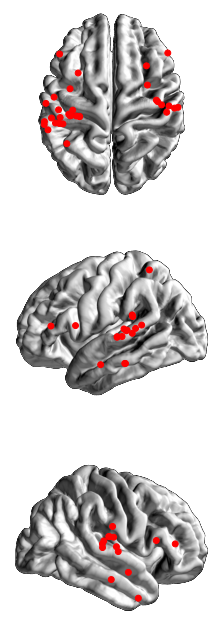

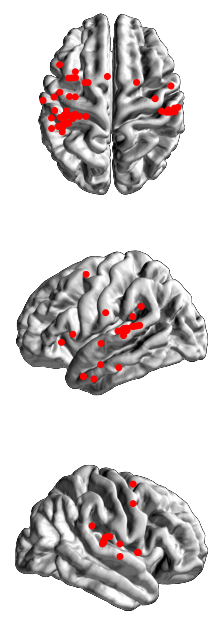

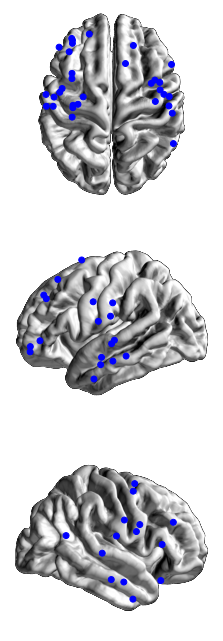

In [44]:

'''
#plotting
plt.figure(figsize=(3,1.7))
for subject in subject_list:
    plt.plot(mean_eng[subject])
plt.title('eng H - all subjects')
plt.xticks([0,1,2], ['speech','music','rest'], fontsize=10)
plt.ylabel('mean eng', fontsize=10)
plt.tight_layout()
plt.savefig(path+'figure/'+ 'engament of H - across conditions - all subjects', dpi=600)
plt.show()
plt.close()'''


        
for o, sound in enumerate(['speech','music', 'rest']):
    fig, ax= plt.subplots(3,1, figsize=(3,9))
    if sound=='rest':
        colors='blue'
    else:
        colors='red'
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                if orientation == 'left':
                    cmap=[]
                    for i in range(len(eng_simple[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((eng_simple[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(eng_simple[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((eng_simple[sound][subject][right_i]))[i,:]))
                
                    
                    
            elif orientation == 'top':
                cmap=[]
                for i in range(len(eng_simple[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((eng_simple[sound][subject]))[i,:]))
                x_h = coordinates
                
                
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color=colors, s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject][left_i]))
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color=colors, s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject][right_i]))
                
            if orientation =='top':
                axes.scatter(*x_h.T, color=colors, s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject]))

                
            #axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])
    
    plt.tight_layout(pad=0.35)
    plt.savefig(path+'figure/brain_plots_all_channels_thres6std_zscoring_AE'+sound+'.png', dpi=600)


In [51]:
for o, sound in enumerate(['speech','music', 'rest']):
    for isub,subject in enumerate(subject_list[:-16]):            
           
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            print(f['atlasses'].keys())
            print(f['atlasses']['Brainnetome'][...][0][:5])

            
            #print('chnames', f['chnames'].shape)
            

<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'STG, '
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'Hipp,'
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'FuG, '
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'STG, '
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'Hipp,'
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainne

# The code for figure 3 - the study of troughs

Here we repeat the exact procedure as before, selecting not the most correlated windows of time but the worst correlated ones.

In [138]:
ind={}
ind_all={}

for sound in sound_list:
    
    ind[sound]={}
    corr_thres=np.percentile(dcorr_all[sound], 1)
    ind_all[sound]=np.where(dcorr_all[sound]<corr_thres)[0]
   
    """for subject in subject_list:
    
        corr_thres=np.percentile(dcorr[sound][subject], 1)

        ind[sound][subject]=np.where(dcorr[sound][subject]<corr_thres)[0]"""


Computation of the time indices corresponding to the time windows in which the inter-subject correlation is lower.

In [139]:
index_all=dict()
for sound in sound_list:
    
    aall=set()
    for i in ind_all[sound]:
        aall.update(np.arange(i,i+window_length))
            
    index_all[sound]=list(aall)

m=min(len(index_all['speech']), len(index_all['music']))
print(len(index_all['speech']), len(index_all['music']))
for sound in ['speech', 'music']:
    index_all[sound]=index_all[sound][:m]
    


1755 2672


The null models for all the conditions. This procedure as a not indifferent computational cost. Because of that we save the results in the end. 

In [140]:
n_iterations=1000

engagement={}
engagementr={}

meta_engagement={}
engagement_null_mean={}
engagement_null_std={}
engagement_null_mean['speech']={}
engagement_null_std['speech']={}
engagement_null_mean['music']={}
engagement_null_std['music']={}
data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)
    
    
    #speech null model
    avalanches=av.go_avalanches(zdata['speech'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['speech'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['speech'][subject]=np.std(engagement_null, axis=0)
    
    
    #music null model
    avalanches=av.go_avalanches(zdata['music'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['music'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['music'][subject]=np.std(engagement_null, axis=0)
    
    
for sound in ['music', 'speech']:
    
    engagement[sound]={}    
    engagementr[sound]={}
    meta_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index_all[sound],:]
        print(min(np.sum(aval, axis=1)))
                                                           
        engagementt=np.sum(aval, axis=0)

        engagement[sound][subject]=(engagementt-engagement_null_mean[subject])/engagement_null_std[subject]
        
        meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
           
        engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        print(engagement[sound][subject])
        
sv.saving(engagement, path+'engagement_troughs')
sv.saving(meta_engagement, path+'meta_engagement_troughs' )


2.7761437719778965
2.9744978125454247


KeyboardInterrupt: 

Here we threshold the engagement in the 2 different methods.A 'yes' is printed in the terminal each time a subject has some channels with an engagement higher then the threshold.

In [144]:
engagement=sv.loading( path+'engagement_troughs')
meta_engagement=sv.loading( path+'meta_engagement_troughs')

enga={}
for sound in ['speech','music']:
    enga[sound]={}
    for subject in subject_list:
        #thress=5
        thress=max(meta_engagement[sound][subject])
        print(thress, max(engagement[sound][subject]))
        if thress < max(engagement[sound][subject]):
            print('')
            print('yes')
        enga[sound][subject]=np.where(engagement[sound][subject]>thress,1,0)


3.7998929169443563 4.134790647162713

yes
5.586756477841421 4.718148669486915
3.897957868655255 3.9713051055071427

yes
3.79678378374912 4.364133123841681

yes
4.3559974375713475 3.407174767793895
3.645544515507889 6.665640415257806

yes
2.643907478921373 3.268139541907688

yes
3.2608735562391455 3.9652057131760623

yes
4.614030478292361 3.965508714305009
4.766757084314771 6.18522862302905

yes
4.820578801577677 3.3296571352172126
5.7010461188813855 6.019540189847105

yes
7.443818483509169 8.816905795007951

yes
3.771900333146485 4.086600947927816

yes
3.9202847831292638 4.033433175681596

yes
5.2039261368737115 6.516833680353489

yes
3.737692338974128 3.4092575386420267
4.783188250946411 5.03632352093113

yes
3.334623673923427 3.1870984320073794
5.708112798665167 5.136790149186428
4.466470850333907 10.18090042297443

yes
4.561096763715792 4.623685095650037

yes
3.71740478894777 4.34218587341388

yes
3.9112376853890187 3.7253402711755044
5.664487334830701 5.457437808822177
2.6790683052

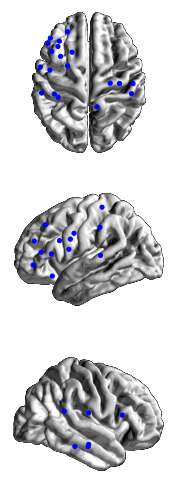

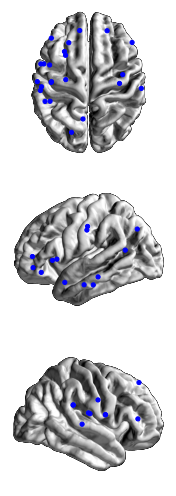

In [147]:

'''
#plotting
plt.figure(figsize=(3,1.7))
for subject in subject_list:
    plt.plot(mean_eng[subject])
plt.title('eng H - all subjects')
plt.xticks([0,1,2], ['speech','music','rest'], fontsize=10)
plt.ylabel('mean eng', fontsize=10)
plt.tight_layout()
plt.savefig(path+'figure/'+ 'engament of H - across conditions - all subjects', dpi=600)
plt.show()
plt.close()'''


        
for o, sound in enumerate(['speech','music']):
    fig, ax= plt.subplots(3,1, figsize=(3,7))
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                if orientation == 'left':
                    cmap=[]
                    for i in range(len(engagement[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(engagement[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject][right_i]))[i,:]))
                
                    
                    
            elif orientation == 'top':
                cmap=[]
                for i in range(len(engagement[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject]))[i,:]))
                x_h = coordinates
                
                
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color='blue', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject][left_i]))
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color='blue', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject][right_i]))
                
            if orientation =='top':
                axes.scatter(*x_h.T, color='blue', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject]))

                
            #axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])

    plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.savefig(path+'figure/brain_plots_all_channels_troughs_maxmetasound_'+sound+'.png', dpi=600)


## Engagement of Helsch Gyrus, is it changing across conditions in the most inter-subject correlated window of time?

In this part we are interested in the study of the engagement of the Helsch gyrus. 



In [124]:
ch_H_i=sv.loading(path+'H_channels_indices_subjects')

In [125]:
eng_simple=sv.loading(path+'engagement_peaks_simple')    

In [126]:
sound_list

['rest', 'music', 'speech']

Plotting

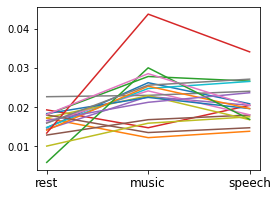

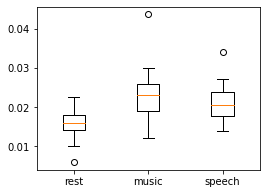

In [149]:


for sound in sound_list:
    zdata=
    for subject in subject_list:

        eng_simple[sound][subject]=np.sum



fs=12
engag={}        
for subject in subject_list:
    engag[subject]=[]
    for sound in sound_list:
        engag[subject].append(np.mean(eng_simple[sound][subject][ch_H_i[subject]]))
        

plt.figure(figsize=(4,3))
for subject in subject_list:
    plt.plot([np.mean(eng_simple['rest'][subject][ch_H_i[subject]]),np.mean(eng_simple['music'][subject][ch_H_i[subject]]),np.mean(eng_simple['speech'][subject][ch_H_i[subject]])])
plt.xticks([0,1,2], sound_list, fontsize=fs)
#plt.ylabel('H norm AE', fontsize=fs)
#plt.tight_layout()
plt.savefig(path+'figure/h_engagement_subjects_lines.png', dpi=600)
plt.show()
plt.close()

engag_boxplot=np.zeros((3,19))

for i, sound in enumerate(sound_list):
    for j, subject in enumerate(subject_list):
        engag_boxplot[i,j]=engag[subject][i]

plt.figure(figsize=(4,3))
plt.boxplot(list(engag_boxplot), labels=sound_list)
#plt.legend(fontsize=fs)
#plt.ylabel('H norm AE', fontsize=fs)
#plt.tight_layout()
plt.savefig(path+'figure/h_engagement_boxplot.png', dpi=600)
plt.show()
plt.close()  



    

    

pvalue computation

In [137]:
ent_random_=np.concatenate((engag_boxplot[0,:], engag_boxplot[2,:]))

real_differ=np.mean(engag_boxplot[2,:])-np.mean(engag_boxplot[0,:])
list_random_corr=[]
count=0
n_it=100000
for i in range(n_it):
    indices=random.sample(range(38), 19)
    ent_random1=ent_random_[indices]
    indices=random.sample(range(38), 19)
    ent_random2=ent_random_[indices]
    differ=np.mean(ent_random1)-np.mean(ent_random2)
    list_random_corr.append(differ)
    if differ>real_differ:
        count+=1

pvalue=count/n_it

if pvalue==0:
    print('for speech vs rest, pvalue <', 1/n_it)
else:
    print('for speech vs rest, pvalue =', pvalue)

ent_random_=np.concatenate((engag_boxplot[0,:], engag_boxplot[1,:]))

real_differ=np.mean(engag_boxplot[1,:])-np.mean(engag_boxplot[0,:])
list_random_corr=[]
count=0
n_it=100000
for i in range(n_it):
    indices=random.sample(range(38), 19)
    ent_random1=ent_random_[indices]
    indices=random.sample(range(38), 19)
    ent_random2=ent_random_[indices]
    differ=np.mean(ent_random1)-np.mean(ent_random2)
    list_random_corr.append(differ)
    if differ>real_differ:
        count+=1

pvalue=count/n_it        
if pvalue==0:
    print('for music vs rest, pvalue <', 1/n_it)
else:
    print('for music vs rest, pvalue =', pvalue)

    

for speech vs rest, pvalue < 1e-05
for music vs rest, pvalue < 1e-05


## VARIOUS ANALYSIS....

In the following part we are going to study the correlation between the dynamical correlation in time window and the engagement in time windows.

1 THE ENGAGEMENT IN TIME WINDOW

In [206]:
n_iterations=400

engagement_null_mean={}
engagement_null_std={}

data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), 200)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)


2.7507264122036497
2.8138171563785437
2.7654285000333187
3.334984151824247
2.7761437719778965
2.9744978125454247
2.774284818922206
2.7985919037396925
2.734310175019014
2.803148765547773
2.8552720483703933
2.78534246404477
2.7331326834817284
2.897258743666651
2.79738475441734
2.750861898649132
2.8089245753814596
2.818625307029934
2.7742837529435107


In [225]:
window_length=50
time_interval=1
d_engagement={}

for sound in ['speech','music']:
    d_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject][sound]
        thres=np.percentile(data[subject]['rest'], 99)
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata.T, thre=thres, direc=0, binsize=2)
        aval=avalanches['Zbin'].T
        t_length=len(aval[0,:])
        n_w=len(np.arange(0, t_length - window_length, time_interval))
        d_engagement[sound][subject]=np.zeros((len(aval),n_w))
        
        print(d_engagement[sound][subject].shape)
        windows=np.arange(0, t_length- window_length, time_interval)
        for i in range(n_w):
            t_start=windows[i]
            d_engagement[sound][subject][:,i] =(np.sum(aval[:,t_start:t_start+window_length], axis=1)-engagement_null_mean[subject])/engagement_null_std[subject]
            
            
            
            
            


(168, 143)
(107, 143)
(123, 143)
(147, 143)
(108, 143)
(167, 143)
(135, 143)
(139, 143)
(116, 143)
(117, 143)
(109, 143)
(110, 143)
(151, 143)
(157, 143)
(86, 143)
(146, 143)
(121, 143)
(150, 143)
(115, 143)
(168, 144)
(107, 144)
(123, 144)
(147, 144)
(108, 144)
(167, 144)
(135, 144)
(139, 144)
(116, 144)
(117, 144)
(109, 144)
(110, 144)
(151, 144)
(157, 144)
(86, 144)
(146, 144)
(121, 144)
(150, 144)
(115, 144)


In [212]:
len(np.arange(0, - window_length, time_interval))

143

In [215]:
(len(aval[0,:])-window_length)/time_interval


142.675

In [222]:


#computations
for sound in sound_list:
    dcorr[sound]={}
    dcorr_matrix[sound]=[]
    mat=[]
    
    for isub, subject in enumerate(subject_list):
        dcorr[sound][subject]=[]
        
        for i in np.arange(0,len(rss_matrix[sound][0,:])-window_length, time_interval):
            dcorr[sound][subject].append(np.sum((np.corrcoef(rss_matrix[sound][:,i:i+window_length])-np.identity(19))[isub,:])/18)
        
        #print(len(dcorr[sound][subject]))
        mat.append(dcorr[sound][subject])
        
    dcorr_matrix[sound]=np.array(mat)
    dcorr_all[sound]=np.mean(np.array(mat), axis=0)
    print('la lunghezza è', dcorr_matrix[sound].shape)

la lunghezza è (19, 141)
la lunghezza è (19, 144)
la lunghezza è (19, 143)


In [229]:
ch_H_i


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114]

The results of this computation

In [173]:
d_engagement['speech'][subject]=np.array(d_engagement['speech'][subject])

In [165]:
final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in ch_H_i]
        final_channels_all[subject]final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in ch_H_i]
        final_channels_all[subject]

(57787, 115)

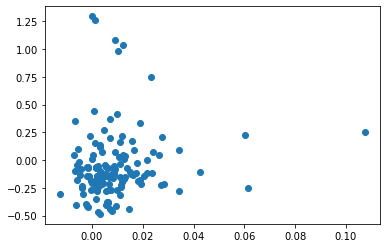

In [237]:
plt.plot(dcorr_all['speech'], np.mean(d_engagement['speech'][subject_list[8]], axis=0), 'o')

In [250]:
sr={}
pval={}
for sound in ['speech', 'music']:
    sr[sound]={}
    pval[sound]={}
    for subject in subject_list:
        ch_i=[i for i, ch in enumerate(final_channels_all[subject]) if ch in final_channels_H]
        print(ch_i)
        n_ch=len(d_engagement[sound][subject][ch_i, :])
        sr[sound][subject]=np.zeros(n_ch)
        pval[sound][subject]=np.zeros(n_ch)

        
        for ch in ch_i:
            sr[sound][subject][ch], pval[sound][subject][ch] = stats.spearmanr(dcorr_all[sound], d_engagement[sound][subject][ch,:])


        
        

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


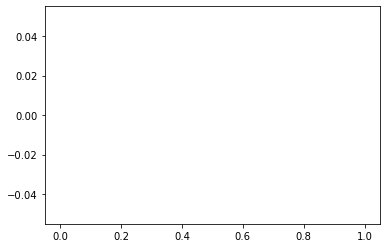

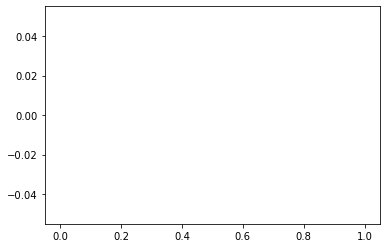

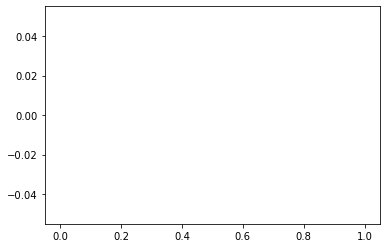

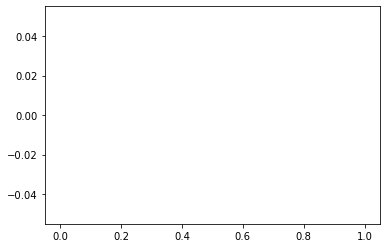

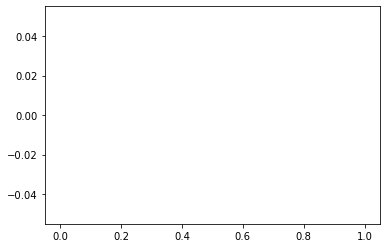

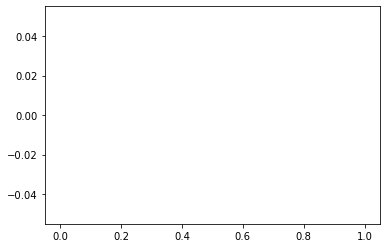

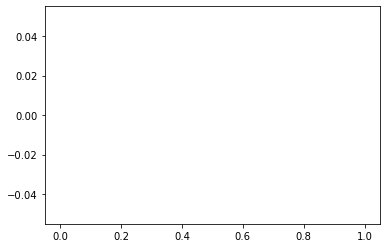

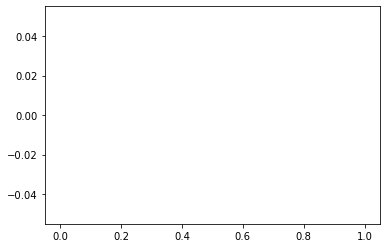

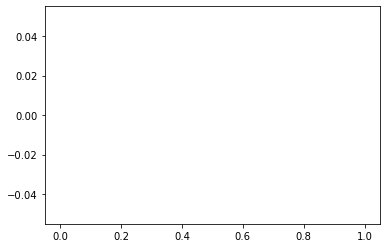

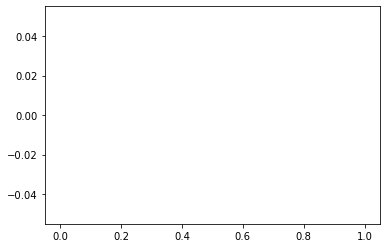

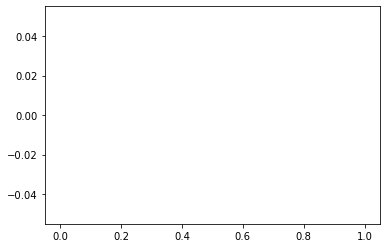

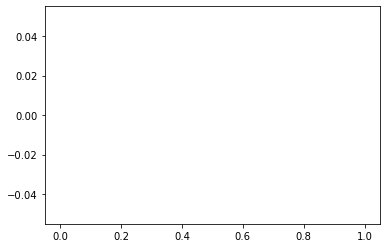

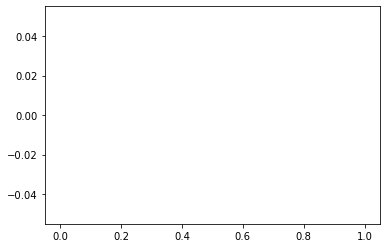

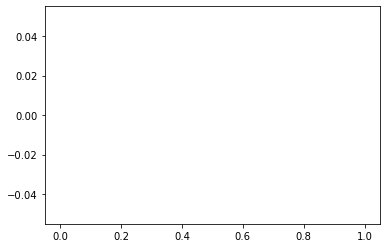

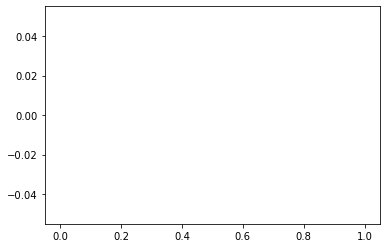

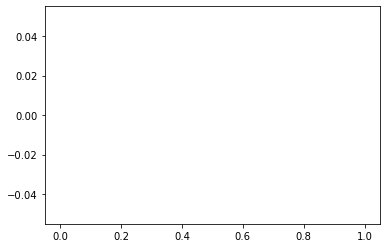

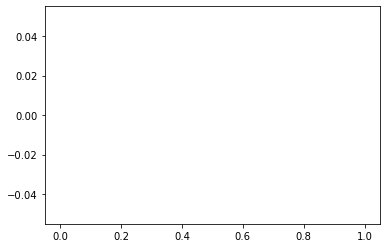

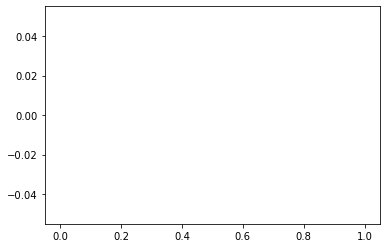

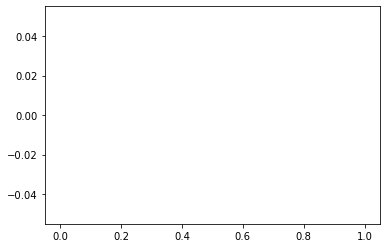

In [249]:
for subject in subject_list:
    
    for sound in ['music','speech']:
        plt.hist(sr[sound][subject])
    plt.show()
    plt.close()

In [176]:
d_engagement['speech'][subject][5,:]


array([-3.64271566, -3.64271566, -3.64271566, ..., -3.64271566,
       -3.64271566, -3.64271566])

In [150]:
index=dict()
for sound in sound_list:
    
    index[sound]={}
    for subject in subject_list:

        aa=set()
        for i in ind[sound][subject]:
            aa.update(np.arange(i,i+window_length))
            
        index[sound][subject]=list(aa)

            
for subject in subject_list:
    m=min(len(index['speech'][subject]), len(index['music'][subject]))
    for sound in ['speech', 'music']:
        index[sound][subject]=index[sound][subject][:m]
        

The indices of the time steps of the binarized dataset corresponding to the most correlated time windows (computed above), are computed in the following way. Below is for the moment when each subject is particularly correlated with the others.

In [114]:

#%%
entropy=dict()
mean_eng=dict()
burstiness=dict()
n_iterations=100
engagement=dict()
engagementr={}
engagement_null_mean={}
engagement_null_std={}

sound='rest'
for isub, subject in enumerate(subject_list):
    
    zdata=sv.loading( path+"data_"+datatipe+'_'+subject) #loading the data of the three conditions that we saved before 

    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
        
    m=len(list(index['speech'][subject]))
    print(m, len(list(index['music'][subject])))      

            
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)
        
for sound in ['music', 'speech']:
    engagement[sound]={}
    engagementr[sound]={}
    
    for subject in subject_list:
        zdata=sv.loading( path+"data_"+datatipe+'_'+subject) #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)
        
        
        corr_thres=np.percentile(dcorr[sound][subject], 99)
        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index[sound][subject],:]

        engagementt=np.sum(aval, axis=0)

        engagement[sound][subject]=(engagementt-engagement_null_mean[subject])/engagement_null_std[subject]
            
        engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        print(engagement[sound][subject])

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/matte/OneDrive/Documenti/matteo/data_hgenv_down100_sub-14c725b6b803'